In [1]:
# project: p6
# submitter: ratushko
# partner: none
# hours: 11

In [2]:
import geopandas as gpd
import pandas as pd
import sqlite3
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rasterio
from rasterio.mask import mask
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

In [3]:
#Q1
counties_gdf = gpd.read_file('counties.geojson')
len(counties_gdf["NAME"])

72

<AxesSubplot:>

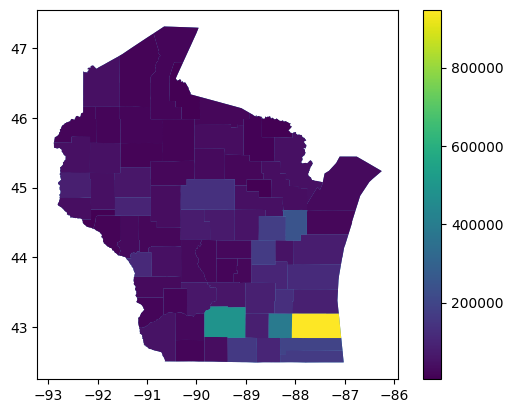

In [4]:
#Q2
ax = counties_gdf.plot()
counties_gdf.plot(ax=ax, column="POP100", legend=True)

In [5]:
#Q3
connection = sqlite3.connect("counties_tracts.db")
arealand = pd.read_sql("""SELECT AREALAND FROM counties""", connection)
counties_gdf["AREALAND"] = arealand

train, test = train_test_split(counties_gdf, random_state=250, test_size=0.25)
list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [6]:
#Q4
xcol = ["AREALAND"]
ycol = ["POP100"]

county_model = LinearRegression()
county_model.fit(train[xcol], train[ycol])
county_model.score(test[xcol], test[ycol])

0.016720430179409274

In [7]:
#Q5
data = pd.DataFrame({"AREALAND" : [400 * (2.59 * 10**6)]})
county_model.predict(data)[0][0]

90000.07422783462

In [8]:
#Q6
connection = sqlite3.connect("counties_tracts.db")
hu100_gdf = pd.read_sql("""
  SELECT counties.name, SUM(HU100) as HU100
  FROM tracts
  LEFT JOIN counties
  ON tracts.county == counties.county
  GROUP BY counties.name
  """, connection)

hu100_gdf = pd.merge(counties_gdf, hu100_gdf, how = "left", on = ["NAME", "NAME"])
train, test = train_test_split(hu100_gdf, random_state=250, test_size=0.25)
list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [9]:
#Q7
dict(zip(test.NAME, test.HU100))

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [10]:
#Q8
xcol = ["HU100"]
ycol = ["POP100"]

county_model = LinearRegression()
county_model.fit(train[xcol], train[ycol])
scores = cross_val_score(county_model, train[xcol], train[ycol], cv=5)
scores.mean()

0.9739348181232653

In [11]:
#Q9
scores.std()

0.01693954236334351

In [12]:
#Q10
coef = county_model.coef_[0][0]
intercept = county_model.intercept_[0]
string = ("POP100 = " + str(round(coef, 2)) + "*HU100 + " + str(round(intercept, 2)))
string

'POP100 = 2.47*HU100 + -9276.89'

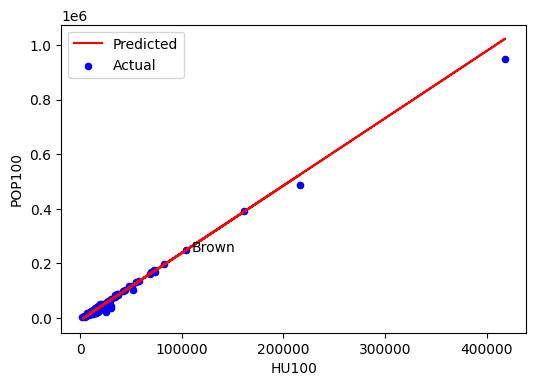

In [13]:
#Q11
fig, ax = plt.subplots(figsize=(6,4))
hu100_gdf["Predicted"] = county_model.predict(hu100_gdf[["HU100"]])
hu100_gdf.plot.line("HU100", "Predicted", ax=ax, color='red')
hu100_gdf.plot.scatter(ax=ax, x='HU100', y='POP100', color='blue', label='Actual')

for val in range(len(hu100_gdf)):
    if hu100_gdf["NAME"][val] == "Brown County":
        brown_x = hu100_gdf["HU100"][val]
        brown_y = hu100_gdf["POP100"][val]
        brown_idx = val
        brown_geometry = hu100_gdf["geometry"][val]

ax.text(x = brown_x + 5000, y = brown_y - 5000, s="Brown")
None

In [14]:
#Q12
a = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

matrix_list = []

for val in a:
    for x in val:
        if x >= 3 and x <= 6:
            matrix_list.append(x)
            
len(matrix_list)

8

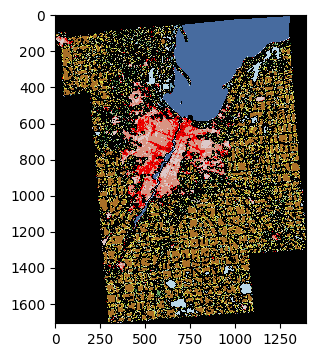

In [15]:
#Q13
counties_gdf = gpd.read_file('counties.geojson')
brown_info = counties_gdf[counties_gdf.NAME == "Brown County"]

land = rasterio.open("zip://../p6/land.zip!wi.tif")
matrix, _ = mask(land, brown_info.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

fig, ax = plt.subplots(figsize=(6,4))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [16]:
#Q14
brown_open_water = sum(sum(matrix==11))
total = sum(sum(matrix != 0))
brown_open_water/total

0.13797526789725206

In [17]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

<AxesSubplot:xlabel='EVERGREEN', ylabel='POP100'>

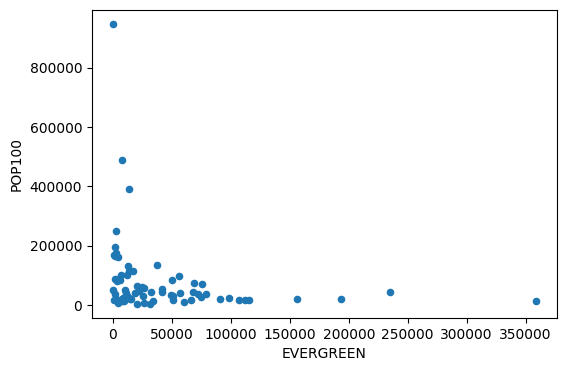

In [18]:
#Q15
counties_gdf = gpd.read_file('counties.geojson')
land = rasterio.open("zip://../p6/land.zip!wi.tif")

evergreen_list = []

for county in counties_gdf["NAME"]:
    df = counties_gdf[counties_gdf["NAME"] == county]
    matrix, _ = mask(land, df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]  
    evergreen = sum(sum(matrix==42))
    evergreen_list.append(evergreen)
    
counties_gdf["EVERGREEN"] = evergreen_list

fig, ax = plt.subplots(figsize=(6,4))
counties_gdf.plot.scatter(ax=ax, x='EVERGREEN', y='POP100')

In [19]:
tracts_gdf = gpd.read_file('tracts.shp')
land = rasterio.open("zip://../p6/land.zip!wi.tif")

feature_dict = {}
for feature in land_use:
    feature_dict[feature] = []

for county in tracts_gdf["GEOID"]:
    df = tracts_gdf[tracts_gdf["GEOID"] == county]
    matrix, _ = mask(land, df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for feature in land_use:
        feature_dict[feature].append(sum(sum(matrix==land_use[feature])))

for key in feature_dict:
    tracts_gdf[key] = feature_dict[key]

In [20]:
train, test = train_test_split(tracts_gdf, random_state=200, test_size=0.20)

xcols = ['open_water',
 'ice_snow',
 'developed_open',
 'developed_low',
 'developed_med',
 'developed_high',
 'barren',
 'deciduous',
 'evergreen',
 'mixed_forest',
 'dwarf_scrub',
 'shrub_scrub',
 'grassland',
 'sedge',
 'lichens',
 'moss',
 'pasture',
 'crops',
 'woody_wetlands',
 'herbacious_wetlands']

tracts_model = LinearRegression()
tracts_model.fit(train[xcols], train["POP100"])

LinearRegression()

Text(0, 0.5, 'Feature Coefficients')

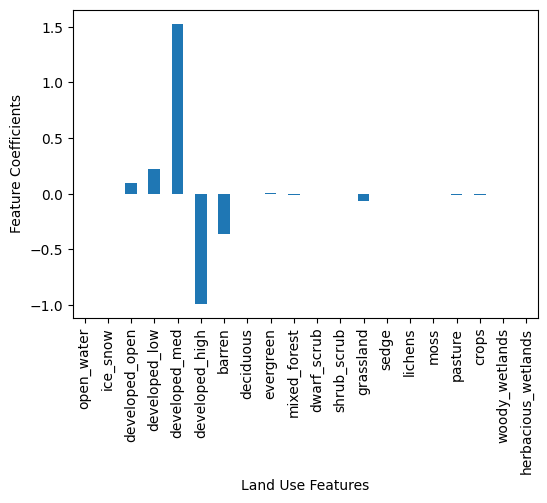

In [21]:
#Q16
ax = pd.Series(tracts_model.coef_, index=xcols).plot.bar(figsize=(6, 4))
ax.set_xlabel("Land Use Features")
ax.set_ylabel("Feature Coefficients")

# This graph is showing the relationship between the POP100 column and all of the corresponding land_use features. It relies
# on developed_med and developed_high the most, with POP100 being impacted positively with the former and negatively with the latter.

In [22]:
train, test = train_test_split(tracts_gdf, random_state=200, test_size=0.20)
model_1 = LinearRegression()
model_1.fit(train[["developed_high"]], train["POP100"])
scores_1 = cross_val_score(model_1, train[["developed_high"]], train["POP100"], cv=5)
print(scores_1.mean())
print(scores_1.var())

model_2 = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression()),
])

xcols = ["developed_med", "developed_high", "grassland"]

scores_2 = cross_val_score(model_2, train[xcols], train["POP100"], cv=10)
print(scores_2.mean())
print(scores_2.var())

0.07205305186293734
0.0005076808676778897
0.42080571485902174
0.023238828978125608


In [23]:
#Q17
model_2.fit(train[xcols], train["POP100"])
model_2.score(test[xcols], test["POP100"])

# I would recommend model_2 for this prediction task, because it achieved a higher mean than model_1, meaning that its 
# explained variance is closer to accurate than model_1. Although model_1 technically has a lower variance than model_2,
# it is not by much, and because the means are significantly different from each other (and we value higher scores), model_2
# is still better (mean and var values for each model shown in print statement above).

0.36043689440916415